# Classification

One of the main goals of hyperspectral image analysis is to classify the constituent materials. There are many different classification techniques; this set of tutorials will cover the following methods:

1. Ordinary Least Squares 
2. Principal Component Analysis (PCA)
3. Support Vector Machine (SVM)

## Ordinary Least Squares Classification

In this exercise, we will test out least squares classification with several example datasets. We will start by bringing in a linearly separated dataset with two classes `LinSepC1.mat` and `LinSepC2.mat` that have no overlapping points. Next we will load in a data set `LinSepC2Coultier.mat` where there is an outlier from one class that falls within the grouping of the 2nd class. Finally, we will try out randomly generated data.

    THESE ARE THE OPTIONS:
    Linearly Separable: LinSepC1, LinSepC2,LinSepC2Outlier (Linearly Separable)
    Nonlinearly Separable: NonLinSepC1, NonLinSepC2, NonLinSepC22

First load example data from the mat files by setting LoadClasses = True, and make sure the following entries in the first cell match the following. If the data is not stored in the working directory, be sure to include the relative path to where the data is located.

   - ` InFile1          = 'LinSepC1.mat' `
   - ` InFile2          = 'LinSepC2.mat' `
   - ` C2               = C2Dict['LinSepC2']`
   
Next try: 

   - ` InFile1          = 'LinSepC1.mat' `
   - ` InFile2          = 'LinSepC2Outlier.mat' `
   - ` C2               = C2Dict['LinSepC2Outlier']`

Then to generate random numbers , set LoadClasses to False:

   - ` LoadClasses    = False`

Import the required packages. We will use the scipy package here to run some linear algebra routines. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg #linear algebra 
from scipy import io

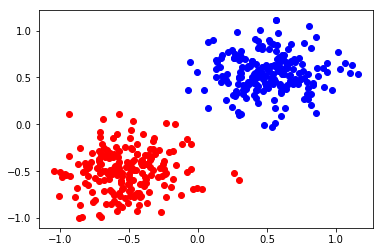

In [2]:
### Ordinary Least Squares
### SOLVES 2-CLASS LEAST SQUARES PROBLEM

### LOAD DATA ###
### IF LoadClasses IS True, THEN LOAD DATA FROM FILES ###
### OTHERWISE, RANDOMLY GENERATE DATA ###
LoadClasses    = True
TrainOutliers  = False
TestOutliers   = False
NOut           = 20
NSampsClass    = 200
NSamps         = 2*NSampsClass

if LoadClasses:
    
    ### GET FILENAMES ###
    ### THESE ARE THE OPTIONS ###
    ### LinSepC1, LinSepC2,LinSepC2Outlier (Still Linearly Separable) ###
    ### NonLinSepC1, NonLinSepC2, NonLinSepC22 ###
    
    InFile1          = '../data/PaulGader/LinSepC1.mat'
    InFile2          = '../data/PaulGader/LinSepC2.mat' #Change to LinSepC2Outlier for 2nd try
    C1Dict           = io.loadmat(InFile1)
    C2Dict           = io.loadmat(InFile2)
    C1               = C1Dict['LinSepC1']
    C2               = C2Dict['LinSepC2']
    
    if TrainOutliers:
        ### Generate Some Noise ###
        Out1        = 2*np.random.rand(NOut,2)-0.5
        Out2        = 2*np.random.rand(NOut,2)-0.5
        C1          = np.concatenate((C1,Out1),axis=0)
        C2          = np.concatenate((C2,Out2),axis=0)
        NSampsClass = NSampsClass+NOut
        NSamps      = 2*NSampsClass
else:
    ### Randomly Generate Some Data
    ### Make covariance matrices using a diagonal array and rotation matrix
    pi      = 3.141592653589793
    Lambda1 = 0.25
    Lambda2 = 0.05
    DiagMat = np.array([[Lambda1, 0.0],[0.0, Lambda2]])
    RotMat  = np.array([[np.sin(pi/4), np.cos(pi/4)], [-np.cos(pi/4), np.sin(pi/4)]])
    mu1     = np.array([0,0])
    mu2     = np.array([1,1])
    Sigma   = np.dot(np.dot(RotMat.T, DiagMat), RotMat)
    C1      = np.random.multivariate_normal(mu1, Sigma, NSampsClass)
    C2      = np.random.multivariate_normal(mu2, Sigma, NSampsClass)
    print(Sigma)
    print(C1.shape)
    print(C2.shape)

### PLOT DATA ###
plt.figure(1)
plt.plot(C1[:NSampsClass, 0], C1[:NSampsClass, 1], 'bo')
plt.plot(C2[:NSampsClass, 0], C2[:NSampsClass, 1], 'ro')
plt.show()

Set up target outputs and plot:

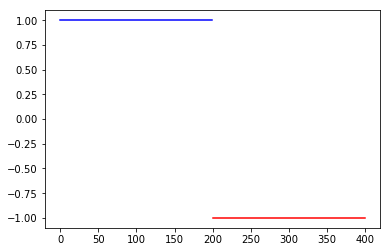

In [3]:
### SET UP TARGET OUTPUTS ###
TargetOutputs          = np.ones((NSamps,1)) #Set 1st half (400 values) to 1s
TargetOutputs[NSampsClass:NSamps] = -TargetOutputs[NSampsClass:NSamps] 
#Set 2nd half to -1s (now 1st 200 are 1, 2nd 200 are -1)

### PLOT TARGET OUTPUTS ###
plt.figure(2)
plt.plot(range(NSampsClass),         TargetOutputs[range(NSampsClass)],   'b-')
plt.plot(range(NSampsClass, NSamps), TargetOutputs[range(NSampsClass, NSamps)], 'r-')
plt.show()

### Calculate the Ordinary Least Squares Solution:

For a function $$y = Xw$$ we want to minimize the squared error:

$$F(X,w) = ||Xw-y||^2$$

Solve for the weighting factors to get:

$$ w = (X^TX)^{-1} X^Ty $$

In [4]:
### FIND LEAST SQUARES SOLUTION ###

#concatenate two classes into a single array with shape (400,2)
AllSamps     = np.concatenate((C1,C2),axis=0) 
#before classes were separated into two arrays; axis tells you the way you are concatenating

#calculate the matrix X:
#add ones to last column -- this adds the y-intercept (i.e. shifts line up and down)
AllSampsBias = np.concatenate((AllSamps, np.ones((NSamps,1))), axis=1) 

#calculate pseudo-inverse
Pseudo       = linalg.pinv2(AllSampsBias)

#multipy pseudo-inverse by the target outputs to get the weighting factors
w            = Pseudo.dot(TargetOutputs) #weights (parameters you are trying to estimate)

In [5]:
# Display the shapes of the original samples and the concatenated ones:
# print('C1 shape:',C1.shape)
# print('C2 shape:',C2.shape)
# print('AllSamps shape:',AllSamps.shape)
print('AllSampsBias (X):\n',AllSampsBias)
print('weighting factors (w):\n',w)

AllSampsBias (X):
 [[ 0.65064361  0.80005432  1.        ]
 [ 0.35038179  0.27897928  1.        ]
 [ 0.41048512  0.90650434  1.        ]
 ..., 
 [-0.55857876 -0.62424968  1.        ]
 [-0.74494222 -0.80221719  1.        ]
 [-0.37718766 -0.41855987  1.        ]]
weighting factors (w):
 [[ 0.81592447]
 [ 0.94178188]
 [-0.01663028]]


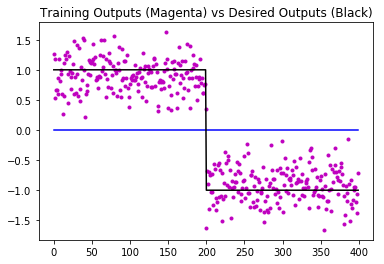

In [6]:
### COMPUTE OUTPUTS ON TRAINING DATA ###
y = AllSampsBias.dot(w) #calculate y from the least squares

### PLOT OUTPUTS FROM TRAINING DATA ###
plt.figure(3)
plt.plot(range(NSamps), y, 'm.')
plt.plot(range(NSamps),np.zeros((NSamps,1)), 'b') #Zero is the classification "threshold"
plt.plot(range(NSamps), TargetOutputs, 'k')
plt.title('Training Outputs (Magenta) vs Desired Outputs (Black)')
plt.show()

The blue line at zero is the decision criteria for classification. You can see that with this linearly seperable data set, all of the data were correctly classified. 

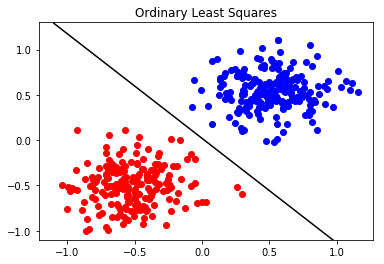

In [7]:
### CALCULATE AND PLOT LINEAR DISCRIMINANT ###
Slope     = -w[1]/w[0]
Intercept = -w[2]/w[0]
Domain    = np.linspace(-1.1, 1.1, 60) #Tile the decision surface over the range
Disc      = Slope*Domain+Intercept

plt.figure(4)
plt.plot(C1[:NSampsClass, 0], C1[:NSampsClass, 1], 'bo')
plt.plot(C2[:NSampsClass, 0], C2[:NSampsClass, 1], 'ro')
plt.plot(Domain, Disc, 'k-')
plt.ylim([-1.1,1.3])
plt.title('Ordinary Least Squares')
plt.show()

Ridge Regression -- Diagonally Load by adding $$\lambda$$

In [8]:
RegConst      = 0.1 #set lambda to 0.1
AllSampsBias  = np.concatenate((AllSamps, np.ones((NSamps,1))), axis=1)

#calculate transpose of matrix 
AllSampsBiasT = AllSampsBias.T

#multiply the transpose by the original matrix (XTX)
XtX           = AllSampsBiasT.dot(AllSampsBias)

#Add regularization constant term (lambda) 
AllSampsReg   = XtX + RegConst*np.eye(3) #np.eye(3) is the 3x3 identity matrix 
Pseudo        = linalg.pinv2(AllSampsReg) #take the pseudo-inverse
wr            = Pseudo.dot(AllSampsBiasT.dot(TargetOutputs)) #calculate ridge regression weights 

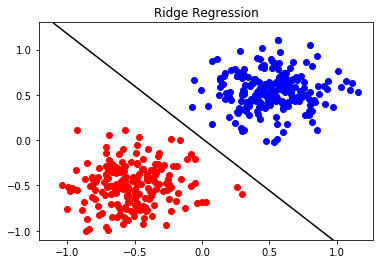

In [9]:
Slope     = -wr[1]/wr[0]
Intercept = -wr[2]/wr[0]
Domain    = np.linspace(-1.1, 1.1, 60)
Disc      = Slope*Domain+Intercept

matplotlib.pyplot.figure(5)
matplotlib.pyplot.plot(C1[:NSampsClass, 0], C1[:NSampsClass, 1], 'bo')
matplotlib.pyplot.plot(C2[:NSampsClass, 0], C2[:NSampsClass, 1], 'ro')
matplotlib.pyplot.plot(Domain, Disc, 'k-')
matplotlib.pyplot.ylim([-1.1,1.3])
matplotlib.pyplot.title('Ridge Regression')
matplotlib.pyplot.show()

Save this project with the name: OLSandRidgeRegress2DPGader.  Make a New Project for Spectra.

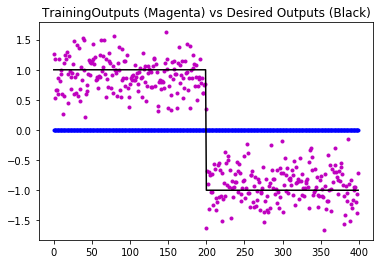

In [10]:
### COMPUTE OUTPUTS ON TRAINING DATA ###
yr = AllSampsBias.dot(wr)

### PLOT OUTPUTS FROM TRAINING DATA ###
plt.figure(6)
plt.plot(range(NSamps), yr, 'm.')
plt.plot(range(NSamps),np.zeros((NSamps,1)), 'b')
plt.plot(range(NSamps), TargetOutputs, 'k')
plt.title('TrainingOutputs (Magenta) vs Desired Outputs (Black)')
plt.show()

In [11]:
#Ordinary Least Squares
y1 = y[range(NSampsClass)]
y2 = y[range(NSampsClass, NSamps)]
Corr1 = np.sum([y1>0]) #of correctly classified points in first class
Corr2 = np.sum([y2<0]) #of correctly classified points in second class

#Ridge Regression
y1r = yr[range(NSampsClass)]
y2r = yr[range(NSampsClass, NSamps)]
Corr1r = np.sum([y1r>0])
Corr2r = np.sum([y2r<0])

In [12]:
print('Result for Ordinary Least Squares')
CorrClassRate=(Corr1+Corr2)/NSamps
print(Corr1 + Corr2, 'Correctly Classified for a', round(100*CorrClassRate), '% Correct Classification \n')

print('Result for Ridge Regression')
CorrClassRater=(Corr1r+Corr2r)/NSamps
print(Corr1r + Corr2r, 'Correctly Classified for a', round(100*CorrClassRater), '% Correct Classification \n')

Result for Ordinary Least Squares
400 Correctly Classified for a 100.0 % Correct Classification 

Result for Ridge Regression
400 Correctly Classified for a 100.0 % Correct Classification 



In [13]:
### Make Confusion Matrices ###

# A confusion matrix tells you how many you got right v. wrong 
# If all are right, should be 100% along the diagonal 
NumClasses = 2;
Cm         = np.zeros((NumClasses,NumClasses))
Cm[(0,0)]  = Corr1/NSampsClass
Cm[(0,1)]  = (NSampsClass-Corr1)/NSampsClass
Cm[(1,0)]  = (NSampsClass-Corr2)/NSampsClass
Cm[(1,1)]  = Corr2/NSampsClass
Cm           = np.round(100*Cm)
print('Confusion Matrix for OLS Regression \n', Cm, '\n')

Cm           = np.zeros((NumClasses,NumClasses))
Cm[(0,0)]    = Corr1r/NSampsClass
Cm[(0,1)]    = (NSampsClass-Corr1r)/NSampsClass
Cm[(1,0)]    = (NSampsClass-Corr2r)/NSampsClass
Cm[(1,1)]    = Corr2r/NSampsClass
Cm           = np.round(100*Cm)
print('Confusion Matrix for Ridge Regression \n', Cm, '\n')

Confusion Matrix for OLS Regression 
 [[ 100.    0.]
 [   0.  100.]] 

Confusion Matrix for Ridge Regression 
 [[ 100.    0.]
 [   0.  100.]] 



EXERCISE:  Run Ordinary Least Squares and Ridge Regression on Spectra and plot the weights

- Least Squares tends to favor classes that have more samples (best way to minimize squared errors is to assign everything to the same class)
- Ridge regression is an example of sparsity - minimizes the weights; with many weights, drives most of them to zero & mitigates over-training. See: http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html
- L2 v. L1: L2 minimizes sum of squares of weights (prefers 1/2 1/2), L1 minimizes absolute values of weights (prefers 1 0) - (`sklearn.linear_model.Lasso`)
- Perceptron algorithm (`sklearn.linear_model.Perceptron`) finds separating line 

For documentation and examples using the scikit learn package, refer to:
- http://scikit-learn.org/stable/user_guide.html
- http://scikit-learn.org/stable/auto_examples/ 

## Additional Reading

Manolakis, Marden, and Shaw, "Hyperspectral image processing for automatic target detection applications", IEEE Signal Processing Magazine, vol. 14, no. 1, pp. 79-116, 2003.